In [1]:
import os
import re
from typing import TypedDict, Optional, Dict, Any
from dotenv import load_dotenv
import warnings

warnings.filterwarnings("ignore")

from langchain_community.tools import ShellTool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START

load_dotenv()

True

In [2]:
# --- 1. Define State ---
class HostCheckState(TypedDict):
    target_ip: str  # Input: IP address to check
    check_intent: str  # Input: User's intent for checking (e.g., "Ping 3 times")
    generated_command_raw: Optional[str]  # Original command generated by LLM
    ping_command: Optional[str]  # Validated ping command
    raw_ping_output: Optional[str]  # Raw output from ping execution
    is_alive: Optional[bool]  # Host availability status
    ping_summary: Optional[str]  # Summary of ping results
    error_message: Optional[str]  # Error message in case of failure

In [3]:
# --- 2. Initialize LLM and Related Components (for Command Generation) ---
try:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
except Exception as e:
    print(f"Error initializing ChatOpenAI: {e}. Please ensure your API key is set correctly.")
    llm = None

# 🚨 This prompt is critical for controlling LLM output and ensuring safety.
PING_COMMAND_GENERATION_PROMPT_TEMPLATE = ChatPromptTemplate.from_messages([
    ("system",
     "You are a network utility expert. Based on the user's intent and target IP, you must generate a 'ping' command. "
     "The generated command must start with 'ping'. "
     "This command should only be used to check the host's availability. "
     "Assume a Linux environment by default when generating the command (e.g., 'ping -c <count> <target IP>'). "
     "If the user's intent includes options like count or interval, reflect them; otherwise, use a default (e.g., 3-4 times). "
     "The target IP address must be correctly included in the command. "
     "The output should be the ping command string only — no explanations or additional text. "
     "If the user's intent is unclear or potentially unsafe, respond exactly with 'Error: Intent unclear or potentially unsafe.'"),
    ("human", "Target IP: {target_ip}\nCheck Intent: {check_intent}\n\nPing Command to Generate:")
])

if llm:
    ping_command_generation_chain = PING_COMMAND_GENERATION_PROMPT_TEMPLATE | llm | StrOutputParser()
else:
    def fallback_ping_chain(_):
        return "Error: LLM not initialized. Cannot generate ping command."
    ping_command_generation_chain = fallback_ping_chain


In [4]:
ping_command_generation_chain

ChatPromptTemplate(input_variables=['check_intent', 'target_ip'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a network utility expert. Based on the user's intent and target IP, you must generate a 'ping' command. The generated command must start with 'ping'. This command should only be used to check the host's availability. Assume a Linux environment by default when generating the command (e.g., 'ping -c <count> <target IP>'). If the user's intent includes options like count or interval, reflect them; otherwise, use a default (e.g., 3-4 times). The target IP address must be correctly included in the command. The output should be the ping command string only — no explanations or additional text. If the user's intent is unclear or potentially unsafe, respond exactly with 'Error: Intent unclear or potentially unsafe.'"), additional_kwargs={}), HumanMessageProm

In [5]:
# --- 3. Define Node Function ---

def generate_and_validate_ping_command_node(state: HostCheckState) -> HostCheckState:
    print("--- NODE: Generating and validating ping command... ---")
    target_ip = state.get("target_ip")
    check_intent = state.get("check_intent")
    updates: Dict[str, Optional[str]] = {"error_message": None}

    if not target_ip or not check_intent:
        updates["error_message"] = "Error: Target IP or check intent not provided."
        return updates

    try:
        print(f"Requesting LLM to generate ping command (IP: {target_ip}, intent: {check_intent})")
        generated_command_str = ping_command_generation_chain.invoke({
            "target_ip": target_ip,
            "check_intent": check_intent
        })
        updates["generated_command_raw"] = generated_command_str
        print(f"Raw command generated by LLM: '{generated_command_str}'")

        stripped_command = generated_command_str.strip()

        if stripped_command.startswith("Error:"):
            raise ValueError(f"LLM returned an error: {stripped_command}")

        if not stripped_command.startswith("ping "):  # Note: space after 'ping' is important
            raise ValueError("Generated command does not start with 'ping '.")

        if target_ip not in stripped_command:
            # Stronger IP validation might be needed (e.g., via regex)
            print(f"Warning: Target IP ({target_ip}) may not be exactly included in the command. Command: '{stripped_command}'")

        # Basic filter for dangerous keywords (ping is relatively safe, but still needs caution)
        forbidden_keywords = [";", "&&", "||", "`", "$(", "sudo", "rm ", "mv ", "cp ", ">", "<", "|&", "nmap", "nc ", "wget", "curl"]
        for keyword in forbidden_keywords:
            if keyword in stripped_command:
                raise ValueError(f"Command contains forbidden keyword '{keyword}'.")

        # Optionally, further validation on ping flags can be added
        # e.g., overly large packet size (-s) or too short interval (-i)
        # Skipping detailed flag validation in this example

        print(f"Basic validation passed: '{stripped_command}'")
        updates["ping_command"] = stripped_command

    except Exception as e:
        print(f"Error during ping command generation/validation: {e}")
        updates["error_message"] = f"Ping command generation/validation error: {str(e)}"
    
    return updates


In [6]:
def execute_ping_node(state: HostCheckState) -> HostCheckState:
    print("--- NODE: Executing ping... ---")
    updates: Dict[str, Optional[str]] = {"error_message": None}

    if state.get("error_message"):
        print(f"Ping execution skipped due to previous error: {state.get('error_message')}")
        return {}

    ping_command = state.get("ping_command")
    if not ping_command:
        updates["error_message"] = "Error: No ping command to execute."
        return updates

    shell_tool = ShellTool()
    try:
        print(f"Executing command: {ping_command}")
        raw_output = shell_tool.invoke(ping_command)
        updates["raw_ping_output"] = raw_output
    except Exception as e:
        print(f"Error during ping execution: {e}")
        updates["error_message"] = f"Error occurred during ping execution: {str(e)}"
    
    return updates


In [7]:
def parse_ping_results_node(state: HostCheckState) -> HostCheckState:
    print("--- NODE: Parsing ping results... ---")
    updates: Dict[str, Any] = {
        "is_alive": False,
        "ping_summary": "No response or failed to parse.",
        "error_message": state.get("error_message")  # Preserve any previous error
    }

    if state.get("error_message") and not state.get("raw_ping_output"):
        print(f"Parsing skipped due to previous error or missing output: {state.get('error_message')}")
        return updates  # Preserve existing error message and keep is_alive as False

    raw_output = state.get("raw_ping_output")
    if not raw_output:
        updates["error_message"] = "Error: No ping result to parse."
        return updates

    # Parse output based on typical Linux ping format (simplified version)
    # Success example: contains "0% packet loss" or "bytes from", with time=...
    # Failure example: "100% packet loss" or "Destination Host Unreachable"

    if "bytes from" in raw_output.lower() and "time=" in raw_output.lower() and "0% packet loss" in raw_output.lower():
        updates["is_alive"] = True
        updates["ping_summary"] = "Host is alive (0% packet loss)."
    elif "bytes from" in raw_output.lower() and "time=" in raw_output.lower():
        updates["is_alive"] = True
        loss_match = re.search(r"(\d+)% packet loss", raw_output)
        loss_percent = loss_match.group(1) if loss_match else "unknown"
        updates["ping_summary"] = f"Host is alive (responded, {loss_percent}% packet loss)."
    elif "0 received" in raw_output.lower() or "100% packet loss" in raw_output.lower():
        updates["is_alive"] = False
        updates["ping_summary"] = "Host is NOT alive (100% packet loss or 0 received)."
    elif "destination host unreachable" in raw_output.lower():
        updates["is_alive"] = False
        updates["ping_summary"] = "Host is NOT alive (Destination Host Unreachable)."
    elif "name or service not known" in raw_output.lower():
        updates["is_alive"] = False
        updates["ping_summary"] = "Host name or service not known."
        updates["error_message"] = "DNS resolution failed or invalid hostname."
    else:
        # If none of the known conditions matched, provide a short summary from raw output
        summary_lines = raw_output.splitlines()
        if len(summary_lines) > 3:
            updates["ping_summary"] = "\n".join(summary_lines[-3:])
        else:
            updates["ping_summary"] = raw_output[:200]  # First 200 characters
        print(f"Ping result is unclear. Raw output: {raw_output[:100]}...")

    print(f"Parsing result: is_alive={updates['is_alive']}, summary='{updates['ping_summary']}'")
    return updates


In [8]:
# --- 4. Build Graph ---
workflow = StateGraph(HostCheckState)

workflow.add_node("generate_and_validate_ping_command", generate_and_validate_ping_command_node)
workflow.add_node("execute_ping", execute_ping_node)
workflow.add_node("parse_ping_results", parse_ping_results_node)

workflow.set_entry_point("generate_and_validate_ping_command")

In [9]:
def decide_after_command_gen(state: HostCheckState) -> str:
    if state.get("error_message") or not state.get("ping_command"):
        print("--- Condition: Ping command generation/validation failed or no command available. Ending workflow. ---")
        return END
    else:
        print("--- Condition: Ping command generated/validated successfully. Proceeding to execution. ---")
        return "execute_ping"

workflow.add_conditional_edges(
    "generate_and_validate_ping_command",
    decide_after_command_gen,
    {
        "execute_ping": "execute_ping",
        END: END
    }
)


In [10]:
def decide_after_ping_execution(state: HostCheckState) -> str:
    if state.get("error_message") and not state.get("raw_ping_output"):  # Error occurred during execution
        print(f"--- Condition: Ping execution failed ({state.get('error_message')}), ending workflow. ---")
        return END
    else:  # Execution completed (may or may not have valid results)
        print("--- Condition: Ping execution completed (success or failure), proceeding to result parsing. ---")
        return "parse_ping_results"

workflow.add_conditional_edges(
    "execute_ping",
    decide_after_ping_execution,
    {
        "parse_ping_results": "parse_ping_results",
        END: END
    }
)

workflow.add_edge("parse_ping_results", END)


In [11]:
app = workflow.compile()

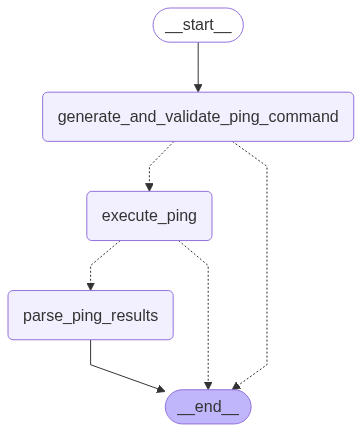

In [12]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
# target_ip_to_check = "127.0.0.1"  # Localhost
target_ip_to_check = "8.8.8.8"  # Google DNS (commonly responds to ping)
# target_ip_to_check = "192.0.2.1"  # Likely unresponsive test IP (TEST-NET-1)
# target_ip_to_check = "nonexistenthostname12345.com"  # To simulate DNS failure

check_intent_for_llm = "Send ping 3 times to check if this host is alive."
# check_intent_for_llm = "Send ping once quickly."

print(f"📢 Starting ping test for: {target_ip_to_check}")
print(f"   User intent: {check_intent_for_llm}")
print("---")

initial_state = {
    "target_ip": target_ip_to_check,
    "check_intent": check_intent_for_llm
}

if not os.getenv("OPENAI_API_KEY") or not llm:
    print("OPENAI_API_KEY is not set or LLM initialization failed. Cannot proceed with the test.")
else:
    try:
        final_state = app.invoke(initial_state, {"recursion_limit": 10})

        print("\n---")
        print("📊 Final Ping Test Result:")
        current_error = final_state.get("error_message")
        if current_error:  # Error message from any stage
            print(f"❌ Error occurred during execution: {current_error}")
        
        print(f"  - Target IP: {final_state.get('target_ip')}")
        print(f"  - User intent: {final_state.get('check_intent')}")
        print(f"  - Raw command generated by LLM: {final_state.get('generated_command_raw')}")
        print(f"  - Validated ping command: {final_state.get('ping_command')}")
        
        is_alive = final_state.get('is_alive')
        if is_alive is not None:
            print(f"  - Host status: {'🟢 Alive (Responding)' if is_alive else '🔴 Unreachable / No Response'}")
        else:
            print("  - Host status: ⚠️ Unknown (parsing failed or execution skipped)")

        print(f"  - Ping summary: {final_state.get('ping_summary')}")

        print("\n--- Raw Output (uncomment for details) ---")
        if final_state.get('raw_ping_output'):
            print(final_state.get('raw_ping_output'))
        else:
            print("(No raw output)")

    except Exception as e:
        print(f"💥 Exception occurred during workflow execution: {e}")
        print("   (Check if the ping utility is installed, ShellTool terminal access is allowed, and OpenAI API key is valid.)")


📢 Starting ping test for: 8.8.8.8
   User intent: Send ping 3 times to check if this host is alive.
---
--- NODE: Generating and validating ping command... ---
Requesting LLM to generate ping command (IP: 8.8.8.8, intent: Send ping 3 times to check if this host is alive.)
Raw command generated by LLM: 'ping -c 3 8.8.8.8'
Basic validation passed: 'ping -c 3 8.8.8.8'
--- Condition: Ping command generated/validated successfully. Proceeding to execution. ---
--- NODE: Executing ping... ---
Executing command: ping -c 3 8.8.8.8
Executing command:
 ping -c 3 8.8.8.8
--- Condition: Ping execution completed (success or failure), proceeding to result parsing. ---
--- NODE: Parsing ping results... ---
Parsing result: is_alive=True, summary='Host is alive (0% packet loss).'

---
📊 Final Ping Test Result:
  - Target IP: 8.8.8.8
  - User intent: Send ping 3 times to check if this host is alive.
  - Raw command generated by LLM: ping -c 3 8.8.8.8
  - Validated ping command: ping -c 3 8.8.8.8
  - Host